# PDAC Calibration - 5y probability changes

Author: Sophie Wagner, sw3767@cumc.columbia.edu

## Packages, notebook preferences, etc.

In [1]:
# Required Packages
import numpy as np  # For matrix manipulation
import pandas as pd  # For output/input data processing
import matplotlib.pyplot as plt  # For visualizations
from csaps import csaps
from tqdm import tqdm
from datetime import datetime
import random 

# Add the src directory to the Python path
import sys
import os
sys.path.append(os.path.abspath('../src'))

# Load .py files
import common_functions as func
import calibration_plots as p
import configs as c
import gof

# Some aesthetic options
np.set_printoptions(suppress=True, linewidth=300, formatter={'float': '{: 0.9f}'.format})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Set up matrix

In [2]:
def row_normalize(matrix):
    
    for age_layer in range(matrix.shape[0]):
        layer = matrix[age_layer, :, :]
        non_diag_sum = np.sum(layer, axis=1) - np.diagonal(layer)

        # Scale rows if non-diagonal sum exceeds 1
        scaling_factors = np.clip(1 / non_diag_sum, None, 1)
        layer *= scaling_factors[:, np.newaxis]  # Scale entire row

        # Adjust diagonal elements to ensure each row sums to 1
        np.fill_diagonal(layer, np.maximum(0, 1 - np.sum(layer, axis=1) + np.diagonal(layer)))

        # Update the matrix for the current age layer
        matrix[age_layer, :, :] = layer

    return matrix.clip(0.0, 1.0)


def create_matrix():
    
    matrix = np.zeros((len(c.age_layers_5y), len(c.health_states_itos), len(c.health_states_itos)))
    age_50_idx = 6
    matrix[:, 0, 1] = (1-(1-0.0011)**(1/25)) # average risk after 50 ~ 0.0011, transformed to annual prob
    matrix[:age_50_idx, 0, 1] = np.linspace(0.000002,matrix[-1,0,1],age_50_idx)
    matrix[:, 1, 2] = 0.45 # c.model_inputs_dict['p_Local_to_Regional_PC']
    matrix[:, 2, 3] = 0.5 # c.model_inputs_dict['p_Regional_to_Distant_PC']
    matrix[:, 1, 4] = 0.05 # c.model_inputs_dict['p_symptom_local'] 
    matrix[:, 2, 5] = 0.3 # c.model_inputs_dict['p_symptom_regional']
    matrix[:, 3, 6] = 0.5 # c.model_inputs_dict['p_symptom_distant']
    
    matrix = add_acm(matrix)  # ACM
    matrix = add_csd(matrix)  # CSD
    matrix = constrain_matrix(matrix)  # constrain
    matrix = row_normalize(matrix)  # normalize

    return matrix


def constrain_matrix(matrix):
    
    matrix[:, 0, 1] = np.maximum(matrix[:,0,1], 0.0000001)
    # matrix[:, 0, 1] = np.maximum.accumulate(matrix[:, 0, 1])
    matrix[:, 1, 2] = np.maximum(matrix[:, 0, 1], matrix[:, 1, 2]).clip(0.00001, 1.0)
    matrix[:, 2, 3] = np.maximum(matrix[:, 1, 2], matrix[:, 2, 3]).clip(0.00001, 1.0)
    matrix[:, 2, 5] = np.maximum(matrix[:, 1, 4], matrix[:, 2, 5]).clip(0.00001, 1.0)
    matrix[:, 3, 6] = np.maximum(matrix[:, 2, 5], matrix[:, 3, 6]).clip(0.00001, 1.0)
    
    # Maintain logical consistency
    matrix[:, 1, 4] = np.minimum(matrix[:, 1, 4], matrix[:, 2, 5])
    matrix[:, 2, 5] = np.minimum(matrix[:, 2, 5], matrix[:, 3, 6])
    
    return matrix


def add_acm(matrix):
    
    matrix[:, :7, 8] = c.acm_5y[:, np.newaxis]
    matrix[:, 8, 8] = 1
    
    return matrix


def add_csd(matrix):  # Constant death rate in calibration
    
    matrix[:, 4, 7] = c.model_inputs_dict['p_local_death']
    matrix[:, 5, 7] = c.model_inputs_dict['p_regional_death']
    matrix[:, 6, 7] = c.model_inputs_dict['p_distant_death']
    matrix[:, 7, 7] = 1
    
    return matrix

## Markov model

In [3]:
def run_markov(matrix, starting_age=20, max_age=84):
    
    current_age = starting_age
    age_layer = 0
    month_pop, pop_log = c.starting_pop, c.starting_pop  # (13, 1)
    inc_log = np.zeros(pop_log.shape)  # to track new incidences in each state
    matrixT = matrix.transpose(0,2,1)  # (13, 9, 9)
    inflow_matrix = np.tril(matrixT, k=-1)
    
    while current_age < max_age:            

        # Matrix multiplication (state transition)
        mat, inflow_mat = matrixT[age_layer], inflow_matrix[age_layer] 
        month_inc = np.matmul(inflow_mat, month_pop)  # (9, 9)(9, 1)->(9, 1)
        month_pop = np.matmul(mat, month_pop)  # (9, 9)(9, 1)->(9, 1)
         
        # Add to log
        inc_log = np.concatenate((inc_log, month_inc), axis=1)  # (13, 65)
        pop_log = np.concatenate((pop_log, month_pop), axis=1)  # (13, 65)
        
        current_age += 1
        if current_age in c.ages_5y:
            age_layer += 1
            
    incidence, incidence_unadj = inc_log.copy(), inc_log.copy()
    dead_factor = np.divide(c.N, c.N - pop_log[7:, :].sum(axis=0))  # inc and prev denominator is out of living only
    prevalence = np.zeros(pop_log.shape) 

    for state in range(9):
        incidence[state, :] = np.multiply(incidence[state, :], dead_factor)
        prevalence[state, :] = np.multiply(pop_log[state, :], dead_factor)

    return incidence, prevalence, incidence_unadj, pop_log

## Calibration

In [4]:
# points = [(0,1)]
age_mids = [22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5]
def step(matrix, step_size, num_adj=3):
    """
    Updates a parameter matrix, using reduced 5-y interval matrix (to reduce number of
    parameters to adjust, faster convergence, smoother parameter change). Randomly 
    selected transitions and age groups are adjusted by a scaled step size, then smoothed
    and interpolated to get yearly values.

    Args:
        matrix (numpy.ndarray): Full parameter matrix for all ages and transitions.
        step_size (float): Scale of parameter adjustments.
        num_adj (int): Number of parameters to modify.

    Returns:
        numpy.ndarray: Updated matrix with smoothed yearly transition probabilities.
    """
    points = list(c.transitions_itos.keys()) 
    step_tp = random.choices(points, k=num_adj)
    step_age = random.choices(c.age_layers_adj, k=num_adj)
    new_matrix = matrix.copy()
        
    for i in range(num_adj):
        (from_state, to_state), age = step_tp[i], step_age[i]
        old_param = new_matrix[age, from_state, to_state] 
        step_param = (old_param * step_size).clip(0.00001, 0.1)
        new_matrix[age, from_state, to_state] += np.random.uniform(low=-step_param, high=step_param)

    new_matrix = csaps([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5], new_matrix, axis=0, smooth=0.01)(age_mids).clip(0.0,1.0)

    new_matrix = add_acm(new_matrix)  # ACM
    new_matrix = add_csd(new_matrix)  # CSD
    new_matrix = constrain_matrix(new_matrix)  # constrain
    new_matrix = row_normalize(new_matrix)  # normalize

    return new_matrix

In [5]:
def progress_report(iteration, best_eval, best_log, ticker, best_t):
    """
    Prints progress report during simulated annealing.
    """
    log_adj, _, inc_log, _ = best_log
    total_dxd = np.sum(inc_log[4:7, :]) / c.N
    print(f"{iteration}: Best Eval: {best_eval:.5f}, PDAC: {total_dxd:.5f}, Tick: {ticker}")
    
    if iteration % 50000 == 0:
        transition_probs = p.extract_transition_probs(best_t, metric="avg")
        print(f"Detailed Progress Report, Iteration = {iteration}")
        print(transition_probs)
        p.plot_vs_seer(log_adj, c.seer_inc)

In [6]:
def obj_fn(tm, obj):
    score = gof.objective(run_markov(tm))
    if obj == "cp":
        score += gof.objective_cp(tm)
    return score

In [7]:
def simulated_annealing(n_iterations, step_size, start_tmat, n_adj=5, starting_temp=1, verbose=False, print_interval=1000, obj=""):
    """
    Performs simulated annealing to optimize a transition matrix.

    Args:
        n_iterations (int): Number of iterations for optimization.
        step_size (float): Step size for parameter adjustments.
        start_tmat (numpy.ndarray): Initial transition matrix.
        n_adj (int): Number of parameters to adjust per step.
        starting_temp (float): Initial temperature for annealing.
        verbose (bool): Whether to print progress reports.
        print_interval (int): Interval for progress reporting.

    Returns:
        numpy.ndarray: Optimized transition matrix.
    """
    initial_score = obj_fn(start_tmat, obj)
    best_t = np.copy(start_tmat)
    best_log = run_markov(best_t)
    best_eval = obj_fn(start_tmat, obj)
    curr_t, curr_eval = best_t, best_eval
    scheduler, ticker, iter_count = 0, 0, 0 

    with tqdm(total=n_iterations, desc="Simulated annealing progress", unit="iteration") as pbar:
        for i in range(n_iterations):
            # Generate candidate solution
            candidate_t = step(np.copy(curr_t), step_size, n_adj)
            candidate_eval = obj_fn(candidate_t, obj)

            # Update best solution
            if candidate_eval < best_eval:
                ticker, scheduler = 0, 0
                best_t, best_eval = np.copy(candidate_t), candidate_eval
                best_log = run_markov(best_t)
                
            else:
                ticker += 1
                iter_count+=1
                scheduler+=1

            # Calculate temperature and Metropolis acceptance criterion
            t = starting_temp / (1 + 0.01 * np.sqrt(iter_count + 1))  # Adaptive cooling
            diff = candidate_eval - curr_eval
            metropolis = np.exp(-diff / t)

            if diff < 0 or np.random.random() < metropolis:
                curr_t, curr_eval = np.copy(candidate_t), candidate_eval

            # Print progress report
            if verbose and i > 0 and i % print_interval == 0:
                progress_report(i, best_eval, best_log, ticker, best_t)

            # Adjust or reset exploration parameters periodically
            if scheduler > 50000:  # Long stagnation
                step_size = np.random.uniform(0.1, 0.3)  # Randomize step size
                starting_temp = np.random.uniform(10, 50)  # Reset temperature
                n_adj = np.random.choice(range(1, 12))  # Random adjustments
                scheduler, iter_count = 0, 0, 0 # Reset 
            elif scheduler > 15000:  # Medium stagnation
                step_size = min(step_size + 0.05, 0.3)  # Increase step size for exploration
                starting_temp = min(starting_temp + 2, 50)  # Boost temperature for exploration
                n_adj = np.random.choice(range(3, 10))  # Randomize number of parameters to adjust
                scheduler, iter_count = 0, 0  # Reset stagnation counter

                
            pbar.update(1)

    print(f"Start: {round(initial_score, 5)}     |     End: {round(best_eval,5)}")
    return best_t

In [8]:
def run_sa(tmat=None, save_all=False, n_iterations=50000, step_size=0.2, n_adj=5, starting_temp=1, print_interval=5000, obj=""):
    
    start_tmat = None
    start_tmat = tmat if tmat is not None else create_matrix()   
    #initial_score = obj_fn(start_tmat, obj)
    #print(f"Initial score: {round(initial_score, 5)}")
    #print("Starting calibration...")
    
    result = simulated_annealing(n_iterations=n_iterations, step_size=step_size, start_tmat=start_tmat, n_adj=n_adj, starting_temp=starting_temp, verbose=True, print_interval=print_interval, obj=obj)
    
    # Gather results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    curr_tmat = result.copy()
    curr_log = run_markov(curr_tmat)
    log_adj, log_prev, log_inc, pop_log = curr_log
    final_score = obj_fn(curr_tmat, obj)
    
    save = save_all
    
    # print("Done.")
    
    # Saving
    if save:
        log_path, tmat_path, plot_path = c.OUTPUT_PATHS["logs"], c.OUTPUT_PATHS["tmats"], c.OUTPUT_PATHS["plots"]
        np.save(f"{tmat_path}/{timestamp}_tmat.npy", curr_tmat)
        # pd.DataFrame(log_adj).to_csv(f"{log_path}/{timestamp}_inc_adj.csv")
        # pd.DataFrame(log_prev).to_csv(f"{log_path}/{timestamp}_prev.csv")
        # pd.DataFrame(log_inc).to_csv(f"{log_path}/{timestamp}_inc_unadj.csv")
        # pd.DataFrame(pop_log.T).to_csv(f"{log_path}/{timestamp}_pop_log.csv")
        p.plot_vs_seer(log_adj, c.seer_inc, save_imgs=True, show_plot=False, outpath=plot_path, timestamp=timestamp)
        p.plot_vs_seer_total(log_adj, c.seer_inc, save_imgs=True, show_plot=False, outpath=plot_path, timestamp=timestamp)

    return curr_tmat

## Run simulated annealing

In [9]:
from scipy.stats import sem, t

def summarize_data(data):
    """
    Returns the min, max, median, mean, and 95% confidence interval of a dataset.
    
    Parameters:
        data (list or numpy array): Input data
    
    Returns:
        dict: Summary statistics
    """
    if len(data) == 0:
        return "Data is empty."
    
    # Convert to numpy array for convenience
    data = np.array(data)
    
    # Summary statistics
    min_val = np.min(data)
    max_val = np.max(data)
    median_val = np.median(data)
    mean_val = np.mean(data)
    
    # Compute 95% confidence interval
    confidence = 0.95
    n = len(data)
    if n > 1:
        std_err = sem(data)
        h = std_err * t.ppf((1 + confidence) / 2, n - 1)
        ci_lower = mean_val - h
        ci_upper = mean_val + h
    else:
        ci_lower = ci_upper = mean_val  # No confidence interval for a single data point

    return pd.DataFrame({
        "min": round(min_val,2),
        "max": round(max_val,2),
        "median": round(median_val,2),
        "mean": round(mean_val,2),
        "95% CI lower": round(ci_lower,2),
        "95% CI upper": round(ci_upper,2)
    }, index=[0])

In [10]:
c.risk

'average'

### Log

double

In [ ]:
result = create_matrix()
result = run_sa(result, True, 100000, step_size=0.2, n_adj=5, starting_temp=5)
# 20250113_0807, Eval 65

In [ ]:
result=np.load("../out/double/tmats/20250113_0807_tmat.npy")
result=run_sa(result, False, 50000, 0.25, 3, 5, obj="cp")
# 20250113_0915   |   Eval: 98.58389, PDAC: 0.01260, Tick: 5821

In [ ]:
result=np.load("../out/double/tmats/20250113_0915_tmat.npy")
result=run_sa(result, True, 50000, 0.25, 3, 5, obj="cp")
# 20250113_0921  |  Eval: 70.85809, PDAC: 0.01243, Median: 4.39 ys

average

In [14]:
result = create_matrix()
result = run_sa(result, False, 50000, step_size=0.2, n_adj=5, starting_temp=5)


C:\Users\sophi\AppData\Local\Temp\ipykernel_51056\2699326569.py:8: RuntimeWarning: divide by zero encountered in divide
  scaling_factors = np.clip(1 / non_diag_sum, None, 1)
Simulated annealing progress:   0%|          | 0/50000 [00:00<?, ?iteration/s]

Simulated annealing progress:  10%|█         | 5033/50000 [00:18<02:47, 268.60iteration/s]

5000: Best Eval: 58.64368, PDAC: 0.00737, Tick: 623


Simulated annealing progress:  20%|██        | 10040/50000 [00:36<02:16, 292.93iteration/s]

10000: Best Eval: 57.32329, PDAC: 0.00731, Tick: 3719


Simulated annealing progress:  30%|███       | 15044/50000 [00:54<02:04, 280.16iteration/s]

15000: Best Eval: 57.32329, PDAC: 0.00731, Tick: 8719


Simulated annealing progress:  40%|████      | 20033/50000 [01:16<01:42, 292.90iteration/s]

20000: Best Eval: 51.05413, PDAC: 0.00729, Tick: 3289


Simulated annealing progress:  50%|█████     | 25057/50000 [01:33<01:16, 325.16iteration/s]

25000: Best Eval: 51.05413, PDAC: 0.00729, Tick: 8289


Simulated annealing progress:  60%|██████    | 30063/50000 [01:49<01:00, 327.14iteration/s]

30000: Best Eval: 51.05413, PDAC: 0.00729, Tick: 13289


Simulated annealing progress:  70%|███████   | 35010/50000 [02:47<05:01, 49.79iteration/s] 

35000: Best Eval: 36.01659, PDAC: 0.00711, Tick: 33


Simulated annealing progress:  80%|████████  | 40008/50000 [04:10<03:58, 41.88iteration/s] 

40000: Best Eval: 36.01659, PDAC: 0.00711, Tick: 5033


Simulated annealing progress:  90%|█████████ | 45010/50000 [05:54<00:45, 109.95iteration/s]

45000: Best Eval: 35.07664, PDAC: 0.00718, Tick: 2802


Simulated annealing progress: 100%|██████████| 50000/50000 [07:05<00:00, 117.42iteration/s]

Start: 11328.90054     |     End: 35.07664


In [15]:
np.save(f"../out/avg/tmats/20250113_1030_tmat.npy", result)

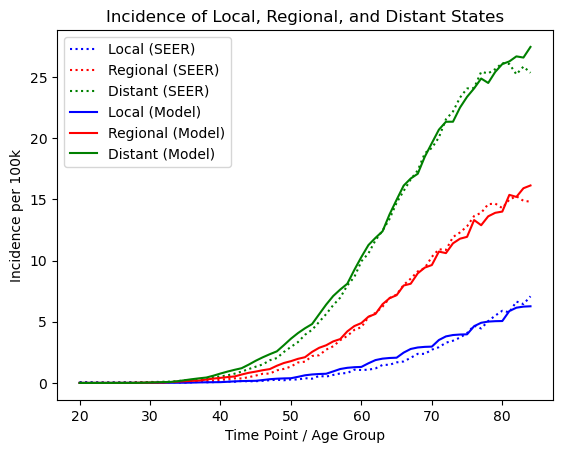

In [16]:
p.plot_vs_seer(run_markov(result)[0], show_plot=True)

In [17]:
summarize_data(gof.cancer_progression(result))

,min,max,median,mean,95% CI lower,95% CI upper
0,2.89,6.78,4.42,4.58,3.82,5.35


Simulated annealing progress:   0%|          | 0/100000 [00:00<?, ?iteration/s]C:\Users\sophi\AppData\Local\Temp\ipykernel_51056\2699326569.py:8: RuntimeWarning: divide by zero encountered in divide
  scaling_factors = np.clip(1 / non_diag_sum, None, 1)
Simulated annealing progress:   5%|▌         | 5001/100000 [01:36<50:48, 31.17iteration/s]  

5000: Best Eval: 81.12393, PDAC: 0.00729, Tick: 454


Simulated annealing progress:  10%|█         | 10021/100000 [04:08<18:58, 79.01iteration/s] 

10000: Best Eval: 42.94376, PDAC: 0.00706, Tick: 993


Simulated annealing progress:  15%|█▌        | 15019/100000 [06:15<16:25, 86.22iteration/s]  

15000: Best Eval: 42.94376, PDAC: 0.00706, Tick: 5993


Simulated annealing progress:  20%|██        | 20012/100000 [07:48<11:54, 111.94iteration/s] 

20000: Best Eval: 42.94376, PDAC: 0.00706, Tick: 10993


Simulated annealing progress:  25%|██▌       | 25013/100000 [09:15<14:53, 83.89iteration/s]  

25000: Best Eval: 42.94376, PDAC: 0.00706, Tick: 15993


Simulated annealing progress:  30%|███       | 30026/100000 [10:02<09:50, 118.41iteration/s]

30000: Best Eval: 42.94376, PDAC: 0.00706, Tick: 20993


Simulated annealing progress:  35%|███▌      | 35022/100000 [10:47<09:49, 110.16iteration/s]

35000: Best Eval: 42.94376, PDAC: 0.00706, Tick: 25993


Simulated annealing progress:  40%|████      | 40016/100000 [11:29<08:34, 116.53iteration/s]

40000: Best Eval: 41.46795, PDAC: 0.00700, Tick: 620


Simulated annealing progress:  45%|████▌     | 45018/100000 [12:13<08:31, 107.46iteration/s]

45000: Best Eval: 41.46795, PDAC: 0.00700, Tick: 5620


Simulated annealing progress:  50%|████▉     | 49995/100000 [13:11<08:15, 101.01iteration/s]

50000: Best Eval: 39.35182, PDAC: 0.00719, Tick: 2200
Detailed Progress Report, Iteration = 50000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00041  0.00001  0.00000  0.00044  0.00018
1  u_PDAC_loc  u_PDAC_reg  0.49102  0.45516  0.45135  0.50894  0.47087
2  u_PDAC_reg  u_PDAC_dis  0.61805  0.56397  0.50649  0.61923  0.58244
3  u_PDAC_loc  d_PDAC_loc  0.05020  0.00725  0.00000  0.07191  0.02641
4  u_PDAC_reg  d_PDAC_reg  0.31011  0.30850  0.26791  0.34458  0.29622
5  u_PDAC_dis  d_PDAC_dis  0.62941  0.88076  0.60222  0.92444  0.77003


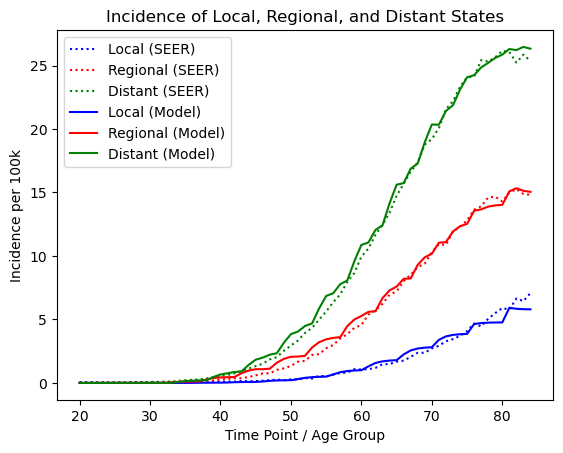

C:\Users\sophi\AppData\Local\Temp\ipykernel_51056\2699326569.py:8: RuntimeWarning: divide by zero encountered in divide
  scaling_factors = np.clip(1 / non_diag_sum, None, 1)
Simulated annealing progress:  55%|█████▌    | 55017/100000 [14:03<06:46, 110.76iteration/s]

55000: Best Eval: 35.80052, PDAC: 0.00712, Tick: 3811


Simulated annealing progress:  60%|██████    | 60015/100000 [15:23<09:05, 73.32iteration/s] 

60000: Best Eval: 35.80052, PDAC: 0.00712, Tick: 8811


Simulated annealing progress:  65%|██████▌   | 65028/100000 [16:51<05:46, 100.99iteration/s]

65000: Best Eval: 33.05386, PDAC: 0.00694, Tick: 867


Simulated annealing progress:  70%|███████   | 70007/100000 [18:35<10:47, 46.29iteration/s] 

70000: Best Eval: 33.05386, PDAC: 0.00694, Tick: 5867


Simulated annealing progress:  75%|███████▌  | 75013/100000 [19:27<03:25, 121.58iteration/s]

75000: Best Eval: 33.05386, PDAC: 0.00694, Tick: 10867


Simulated annealing progress:  80%|████████  | 80015/100000 [20:17<02:57, 112.79iteration/s]

80000: Best Eval: 33.05386, PDAC: 0.00694, Tick: 15867


Simulated annealing progress:  85%|████████▌ | 85006/100000 [21:10<06:37, 37.70iteration/s] 

85000: Best Eval: 33.05386, PDAC: 0.00694, Tick: 20867


Simulated annealing progress:  90%|█████████ | 90001/100000 [23:41<04:32, 36.64iteration/s]

90000: Best Eval: 33.05386, PDAC: 0.00694, Tick: 25867


Simulated annealing progress:  95%|█████████▌| 95007/100000 [25:07<01:59, 41.72iteration/s] 

95000: Best Eval: 33.05386, PDAC: 0.00694, Tick: 30867


Simulated annealing progress: 100%|██████████| 100000/100000 [26:28<00:00, 62.96iteration/s]

Start: 86.78697     |     End: 33.05386


In [18]:
result = run_sa(result, False, 100000, step_size=0.25, n_adj=5, starting_temp=5, obj="cp")

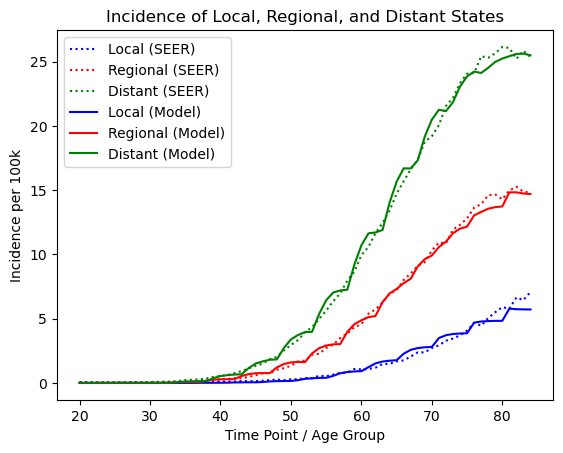

,min,max,median,mean,95% CI lower,95% CI upper
0,2.97,3.8,3.68,3.58,3.43,3.74


In [19]:
np.save(f"../out/avg/tmats/20250113_1050_tmat.npy", result)
p.plot_vs_seer(run_markov(result)[0], show_plot=True)
summarize_data(gof.cancer_progression(result))

### Current

## Post-processing

In [ ]:
result = create_matrix()
result = run_sa(result, True, 100000, step_size=0.2, n_adj=5, starting_temp=5)
# out: 20250113_0807  |  Eval: 65.13903, PDAC: 0.01266

In [28]:
summarize_data(gof.cancer_progression(result))

,min,max,median,mean,95% CI lower,95% CI upper
0,3.85,6.78,6.39,5.89,5.25,6.52


In [28]:
def smooth_tmat(mat, save=False, outpath=c.OUTPUT_PATHS['tmats'], timestamp=""): # (sex: 2, race: 2, age_buckets: 10, state: 18, state: 18)
    
    # Anchor with mean at 100 and Smooth interpolation over age
    tmat_anchored = np.concatenate([mat, np.minimum(mat[-1:, :, :], np.mean(mat, axis=0, keepdims=True))], axis=0) # take mean of values over age buckets and set at age 100 (only if mean lower than last age bucket)
    tmat = csaps([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5], mat, smooth=0.01, axis=0)(np.linspace(20,100,81)) # interpolation without anchoring
    tmat_anchored = csaps([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5,100], tmat_anchored, smooth=0.01, axis=0)(np.linspace(20,100,81)).clip(0.0, 1.0)

    # If smoothed tmat is exp increasing towards end, used anchored probs
    increasing_at_100 = tmat[-2:-1, :, :] < tmat[-1:, :, :]
    tmat_anchored = np.where(increasing_at_100, tmat_anchored, tmat)
    transition_mask = np.zeros((13, 13), dtype=bool)
    from_states, to_states= c.transitions_itos.keys()
    transition_mask[from_states, to_states] = True
    tmat_anchored = np.where(increasing_at_100 & transition_mask[np.newaxis, ...], tmat_anchored, tmat)

    tmat = tmat_anchored
    tmat = row_normalize(tmat)

    if save:
      os.makedirs(outpath, exist_ok=True)
      name = f"tmat_{timestamp}"
      np.save(f"{outpath}/{name}.npy", tmat)
      
    return tmat

In [ ]:
p.plot_params(result, show_plot=True)
markov_tmat = result
treeage_tmat = smooth_tmat(markov_tmat, save=False, timestamp="20241218_1605")
p.plot_params(markov_tmat, treeage_tmat, save_imgs=False, show_plot=True)